In [1]:
import pandas as pd
import os
import json
from collections import Counter
import re
import numpy as np

## Joining Final Annotations and Unmatched Annotations 

In [2]:
PATH_DATA = '../data/'
PATH_DF = '../data/dataframes/'
PATH_FINAL = '../data/final/'

In [3]:
annotations = {}

for file in os.listdir(PATH_DF):
    if file.startswith('annotation') and file.endswith('.tsv'):
        annotator = file.split('_')[-1].split('.')[0]
        annotations[annotator] = pd.read_csv(PATH_DF + file, sep='\t')

all_annotations_df = pd.concat(annotations, ignore_index=True)
all_annotations_df = all_annotations_df.drop_duplicates(ignore_index=True)

In [4]:
final_annotations_df = pd.DataFrame()
interannotated_courses = set()

for file in os.listdir(PATH_FINAL):
    if file.endswith('.tsv'):
        fn = PATH_FINAL + '/' + file
        with open(fn, 'r') as f:
            size = len(f.readlines())
            if size > 0:
                incoming_df = pd.read_csv(fn, delimiter='\t')
                incoming_df = incoming_df.fillna("")
                
                course_number = file.split(".")[0]
                incoming_df["course"] = int(course_number)
                interannotated_courses.add(int(course_number))

                final_annotations_df = pd.concat([final_annotations_df, incoming_df], ignore_index=True)

final_annotations_df = final_annotations_df.drop_duplicates(ignore_index=True)
final_annotations_df = final_annotations_df.drop(columns=['_merge'])

In [5]:
matched_courses = final_annotations_df.course.unique()

In [6]:
unmatched_annotations_df = all_annotations_df[~all_annotations_df.course.isin(interannotated_courses)].reset_index(drop=True)


In [7]:
unmatched_courses = unmatched_annotations_df.course.unique()

In [8]:
product_df = pd.concat([final_annotations_df, unmatched_annotations_df], ignore_index=True)
product_df = product_df.fillna("")
product_df = product_df.drop(columns='collection')
product_df = product_df.drop_duplicates().reset_index(drop=True)

In [9]:
Counter(list(product_df.drop(columns='course').value_counts()))

Counter({3: 6, 2: 82, 1: 8152})

In [10]:
product_df.to_csv('database.tsv', sep='\t', index=False)

In [717]:
# Should maintain index from here 

## Data Cleaning/Processing

In [11]:
def simplify_type(t):
    if t == 'article-journal':
        return "Academic Paper"
    elif t in ['book', 'chapter']:
        return "Book"
    else:
        return "Other"

In [12]:
product_df['type'] = product_df.type.apply(simplify_type)

In [13]:
product_df['year'] = product_df.year.apply(lambda x: str(x).split('-')[0][:4])

In [14]:
def parse_author_name(s):
    if type(s)==float:
        return "" 
    last_name = re.match('.*:family=>"([a-zA-Z]*)"', s)
    if last_name:
        last_name = last_name.group(1)
    else:
        return ""

    first_initial = re.match('.*:given=>"([a-zA-Z\.\s]*)"', s)
    if first_initial:
        first_initial = first_initial.group(1)[0]
        return last_name + ", " + first_initial + "."
    else:
        return last_name


def convert_str_to_list_author(s, return_format):
    """Converts string representation of list into list"""
    authors = re.findall('\{[^\{]*\}', s.strip('[]'))
    parsed_authors = [parse_author_name(a) for a in authors if parse_author_name(a)!='']
    if return_format:
       return '; '.join(parsed_authors)
    return parsed_authors

In [15]:
product_df['author_individual'] = product_df.author.apply(convert_str_to_list_author, return_format='')
product_df['author'] = product_df.author.apply(convert_str_to_list_author, return_format='joined')
product_df.explode('author')

,author,title,type,year,category,course,author_individual
0,"Ott, E.; Sauer, T.; Yorke, J.",Coping with Chaos,Other,1994,Optional,1022,"[Ott, E., Sauer, T., Yorke, J.]"
1,"Wilks, D.",Statistical Methods in the Atmospheric Sciences,Other,1995,Optional,1022,"[Wilks, D.]"
2,"Wunsch, C.",The Ocean Circulation Inverse Problem,Other,1996,Optional,1022,"[Wunsch, C.]"
3,"Kalnay, E.",Atmospheric Modeling,Other,2003,Optional,1022,"[Kalnay, E.]"
4,"Grassberger, P.; Procaccia, I.",Characterization of Strange Attractors,Academic Paper,1983,Required,1022,"[Grassberger, P., Procaccia, I.]"
...,...,...,...,...,...,...,...
8329,"Gesteland, R.",Cross-Cultural Business Behavior: Marketing,Other,1999,Required,1248,"[Gesteland, R.]"
8330,"Kouzes, J.; Posner, B.",The Leadership Challenge,Other,2002,Required,1248,"[Kouzes, J., Posner, B.]"
8331,"Goleman, D.",Leadership that Gets Results,Academic Paper,2000,Required,1248,"[Goleman, D.]"
8332,"Derr, C.; Roussillon, S.; Bournois, F.",Cross-Cultural Approaches to Leadership Develo...,Other,2002,Required,1248,"[Derr, C., Roussillon, S., Bournois, F.]"


In [16]:
# Load index-link mappings
with open(PATH_DATA + 'all_topics.json', encoding='utf-8') as f:
    topics = json.load(f)

annotated_topics = {course: topics for course, topics in topics.items() if int(course) in product_df.course.values}

In [17]:
topic_counter = Counter([t for topics in annotated_topics.values() for t in topics])

In [18]:
product_df['topics'] = product_df['course'].apply(lambda x: annotated_topics[str(x)])
product_df = product_df.explode('topics')

In [19]:
product_df[product_df.topics=='Mathematics'].groupby('category').count()/topic_counter['Mathematics']

,author,title,type,year,course,author_individual,topics
category,,,,,,,
Optional,6.822222,6.822222,6.822222,6.822222,6.822222,6.822222,6.822222
Required,6.688889,6.688889,6.688889,6.688889,6.688889,6.688889,6.688889


In [20]:
# Load index-link mappings
f = open(PATH_DATA + 'index_to_link.json', encoding='utf-8') 
index_to_link = json.load(f)
f.close()

In [21]:
product_df = product_df[product_df.author!=""]
product_df = product_df[product_df.title!=""]

In [23]:
product_df.to_csv('database.tsv', sep='\t', index=False)

In [742]:
def search_readings(TOPIC='Mathematics', FORMAT='All', INCLUDE='All'):
    # Topic selection (Mandatory)
    selection = product_df[product_df.topics==TOPIC].copy()

    # Format selection (if specified)
    if FORMAT in ['Book', 'Academic Paper']:
        selection = selection[selection.type == FORMAT]

    # Include categories (if specified)
    if INCLUDE == 'Required Only':
        selection = selection[selection.category == 'Required']
    elif INCLUDE == 'Optional Only':
        selection = selection[selection.category == 'Optional']

    num_courses = len(selection.course.unique())
    num_readings = selection.shape[0]

    title_df = selection.copy()
    title_df = title_df.sort_values('title') 
    title_df['Link to Course'] = title_df.course.apply(lambda x: index_to_link[str(x)])
    title_df = title_df.drop(columns=['type', 'author_individual', 'course', 'topics'])
    title_df = pd.DataFrame(title_df.value_counts()).reset_index()
    title_df = title_df.drop(columns=['category', 0])

    author_df = selection.copy()
    author_df = author_df.drop(columns=['author', 'topics'])
    author_df = author_df.explode('author_individual')

    author_df = pd.DataFrame(author_df.author_individual.value_counts()).reset_index().rename(columns={'index': 'Author', 'author_individual': '# of Readings'})

    return (num_readings, num_courses), title_df, author_df, selection


In [743]:
search_readings('-Language', 'Book', 'All')[1]

,author,title,year,Link to Course
0,"Aanestad, M.",Strategies for Development and Integration of ...,2005,https://ocw.mit.edu/courses/21g-034-media-educ...
1,"Adeyemi, A.",A Study on the Use of Information Systems to P...,Marc,https://ocw.mit.edu/courses/21g-034-media-educ...
2,"Annamalai, K.; Rao, S.",What Works: ITC’s e-Choupal and Profitable Rur...,2003,https://ocw.mit.edu/courses/21g-034-media-educ...
3,"Casas, C.; LaJoie, W.",Voxiva. Case Study,2003,https://ocw.mit.edu/courses/21g-034-media-educ...
4,"Compaine, B.; Weinramb, M.",Universal Access to Online Services: An Examin...,2001,https://ocw.mit.edu/courses/21g-034-media-educ...
5,"Larson, R.; Murray, M.",Distance Learning as a Tool for Poverty Reduct...,2005,https://ocw.mit.edu/courses/21g-034-media-educ...
6,"Phipps, K.; Sangudi, G.; Woolway, S.",What Works: Healthnet Uganda’s Evolution from ...,2003,https://ocw.mit.edu/courses/21g-034-media-educ...
7,"Prahalad, C.",The Fortune at the Bottom of the Pyramid: Erad...,2004,https://ocw.mit.edu/courses/21g-034-media-educ...
8,"Telecommunications, N.; Administration, I.",Falling through the Net: Defining the Digital ...,2001,https://ocw.mit.edu/courses/21g-034-media-educ...


In [25]:
with open('topic_dropdown.txt', 'w') as f:
    f.writelines([t[1:]+'\n' for t, c in topic_counter.items() if t.startswith('-') and not t.startswith('--')])

In [745]:
# average reading, opt, required
# book / paper / unknown 
# year histogram 
# top authors 

<Axes: xlabel='topics'>

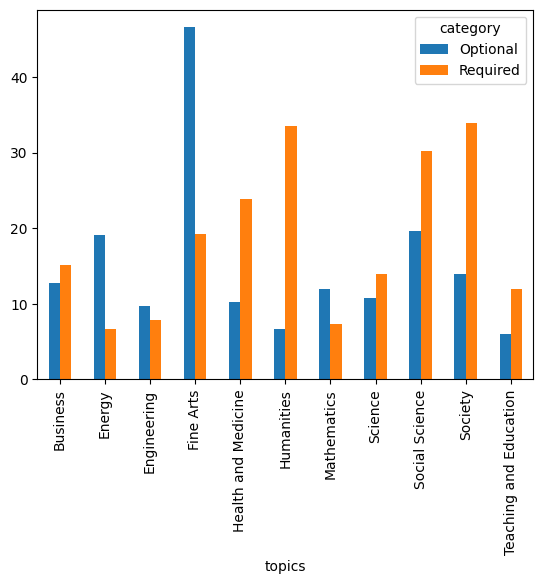

In [813]:
viz_df = product_df[~product_df.topics.str.startswith('-', na=False)].groupby(['topics', 'category']).agg({'title': len, 'course': lambda x: len(set(x.to_list()))}).reset_index()
viz_df['Average Reading per Course'] = round(viz_df['title'] / viz_df['course'], 1)
viz_df[['topics', 'category', 'Average Reading per Course']].pivot(index='topics', columns='category', values='Average Reading per Course').plot(kind='bar')

In [779]:
product_df[~product_df.topics.str.startswith('-', na=False)].groupby(['topics', 'category']).count()['title']

topics                  category
Business                Optional     243
                        Required     558
Energy                  Optional     134
                        Required      67
Engineering             Optional    1063
                        Required    1175
Fine Arts               Optional     233
                        Required     232
Health and Medicine     Optional      31
                        Required     191
Humanities              Optional      80
                        Required     941
Mathematics             Optional     276
                        Required     278
Science                 Optional     628
                        Required    1039
Social Science          Optional    1318
                        Required    3620
Society                 Optional     112
                        Required     476
Teaching and Education  Optional       6
                        Required      24
Name: title, dtype: int64